In [1]:
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, ConcatDataset, Subset
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.utils import make_grid
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import time 
import pathlib
from PIL import Image
from sklearn import metrics
import os
import math
import csv

In [2]:
class augmented_dataset(Dataset):
    def __init__(self, targ_dir):
        self.paths = list(pathlib.Path(targ_dir).glob("*.jpg"))
        self.classes = ['Correct']
        self.class_to_idx = {'Classes':0}
        self.data = [(img, 'augm1') for img in self.paths]
        self.data.extend([(img, 'augm2') for img in self.paths])
        self.data.extend([(img, 'augm3') for img in self.paths])
        self.transform1 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.ColorJitter(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
        self.transform2 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
        self.transform3 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomVerticalFlip(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):

        if self.data[i][1] == 'augm1':
            img = Image.open(self.data[i][0])
            img = self.transform1(img)

        if self.data[i][1] == 'augm2':
            img = Image.open(self.data[i][0])
            img = self.transform2(img)

        if self.data[i][1] == 'augm3':
            img = Image.open(self.data[i][0])
            img = self.transform3(img)              

        return img,0

#train and test data directory
data_dir = "PetImages/RevisitedTraining"
correct_label_dir = "PetImages/RevisitedTraining/Correct"

dataset = ImageFolder(data_dir, transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

augmented_dataset = augmented_dataset(correct_label_dir)
print("OOga",len(augmented_dataset))
item1, lab1 = augmented_dataset[0]
# print(item1)

# print("Classes", (dataset.class_to_idx), (dataset.classes))
print(len(dataset))
t1, l1 = dataset[0]
# print(t1)

concat_dataset = ConcatDataset([dataset, augmented_dataset])
print(len(concat_dataset))


#Manually inputting correct proportions of values
# size = 5000
size = len(dataset) - 200
correctsub = torch.randperm(len(augmented_dataset))[:size-1000]
incorrectsub = torch.randperm(len(dataset))[:size]
part1_subset = Subset(augmented_dataset, correctsub)
part2_subset = Subset(dataset,incorrectsub)
new_subset = ConcatDataset([part1_subset,part2_subset])
test, rest = random_split(new_subset, [10000, len(new_subset)-10000])
n = len(rest)
print("Len of augment", len(part1_subset))
print("New subset length",n)
n_train = int(0.8 * n)
train, valid = random_split(rest, [n_train, n-n_train])
# n2 = len(train)
# n_test = int(0.8*n2)
# train, test = random_split(train, [n_test, n2-n_test])
print("Train Len", len(train))
print("Valid Len", len(valid))
print("Test Len", len(test))

n_test = 1000

train_data_size = len(train)
valid_data_size = len(valid)
test_data_size = len(test)


#Loading training and testing set into batches
train_dl = DataLoader(train, batch_size=64, num_workers=0, shuffle=True)
valid_dl = DataLoader(valid, batch_size=64, num_workers=0, shuffle=False)
test_dl = DataLoader(valid, batch_size=64, num_workers=0, shuffle=False)


OOga 33216
112482
145698
Len of augment 33216
New subset length 135498
Train Len 108398
Valid Len 27100
Test Len 10000


In [ ]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Error in callback <function flush_figures at 0x00000238A4AEAA20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [9]:
# Setup GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining checkpoints in training
def checkpoint(model, filename):
    torch.save({
        # 'epoch': current_epoch,
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        # 'loss': loss
    }, filename)

# Resuming the model with the states intact
def resume(model, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

# Loading pretrained model
pretrained_model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)

# Freeze model parameters
for param in pretrained_model.parameters():
    param.requires_grad = False

# Changing final layer of ResNet50 model for transfer learning
fc_inputs = pretrained_model.classifier[1].in_features
print("FC INPUT SIZE - ",fc_inputs)
pretrained_model.classifier = nn.Sequential(
    # nn.Linear(fc_inputs, 2),
    nn.Dropout(0.5),
    nn.Linear(fc_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
    # nn.Sigmoid()
)

# Convert model for use on GPU
pretrained_model = pretrained_model.to(device)

#Define Optimiser and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), weight_decay=1e-5)
# optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

def train_and_validate(model, loss_criterion, optimizer, epochs=20, start_epoch = 0):
    
    if start_epoch > 0:
        start_epoch -= 1
        print("Resuming at model_{}.pt".format(start_epoch))
        resume(model, f"model_{start_epoch}.pt")

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(start_epoch,epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_dl):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_dl):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save current model at each epoch for checkpoints
        path = 'model_'+str(epoch)+'.pt'
        checkpoint(model=model, filename=path)
        # torch.save(model.state_dict(),name)
            
    return model, history, best_epoch

FC INPUT SIZE -  1408


In [ ]:
# Training the model
# Setting the start_epoch variable will determine any checkpoint epoch to start training from
num_epochs = 10
start_epoch = 0

trained_model, history, best_epoch = train_and_validate(pretrained_model, loss_func, optimizer, num_epochs, start_epoch)
print("THE BEST",best_epoch)
torch.save(history, 'history.pt')

Epoch: 1/10
Epoch : 001, Training: Loss - 0.5385, Accuracy - 73.2361%, 
		Validation : Loss - 0.5051, Accuracy - 75.4444%, Time: 257.7086s
Epoch: 2/10
Epoch : 002, Training: Loss - 0.4762, Accuracy - 77.2083%, 
		Validation : Loss - 0.4939, Accuracy - 76.5556%, Time: 116.0112s
Epoch: 3/10
Epoch : 003, Training: Loss - 0.4525, Accuracy - 78.5139%, 
		Validation : Loss - 0.4866, Accuracy - 77.2778%, Time: 95.5536s
Epoch: 4/10
Epoch : 004, Training: Loss - 0.4350, Accuracy - 79.7639%, 
		Validation : Loss - 0.5019, Accuracy - 78.1667%, Time: 103.8718s
Epoch: 5/10
Epoch : 005, Training: Loss - 0.3932, Accuracy - 82.0278%, 
		Validation : Loss - 0.5030, Accuracy - 76.8333%, Time: 104.8317s
Epoch: 6/10
Epoch : 006, Training: Loss - 0.3532, Accuracy - 84.0694%, 
		Validation : Loss - 0.5307, Accuracy - 77.0556%, Time: 82.5115s
Epoch: 7/10
Epoch : 007, Training: Loss - 0.3089, Accuracy - 86.4444%, 
		Validation : Loss - 0.5600, Accuracy - 77.1667%, Time: 51.4763s
Epoch: 8/10
Epoch : 008, Train

[[0.47879417091060766, 0.45155858082459965, 0.773191004975529, 0.7952233677221737], [0.45813966308862614, 0.4185607230335576, 0.7855301874873846, 0.8059106528881899], [0.4523288590948402, 0.4058006344832915, 0.7891922077492224, 0.8080068728768129], [0.44552856942714725, 0.41997943128916815, 0.7907708498740253, 0.809381443290776], [0.4431772655006813, 0.4018965587542229, 0.791941407671161, 0.8147766322860194], [0.43947415602440437, 0.4073819239688493, 0.793842221701042, 0.8138831615284137], [0.435177340863197, 0.4062334817709382, 0.7955712107141986, 0.8132989690557788], [0.4348981433846819, 0.40087567119663936, 0.7977619794175557, 0.8169072164866523], [0.4339397610713763, 0.3948532765714573, 0.7963122060130498, 0.8146391752413458], [0.43113080566621076, 0.40214101826612075, 0.7969243325698406, 0.8112027490999281]]


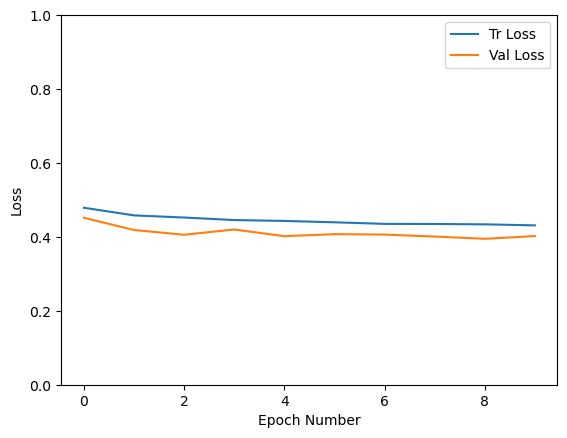

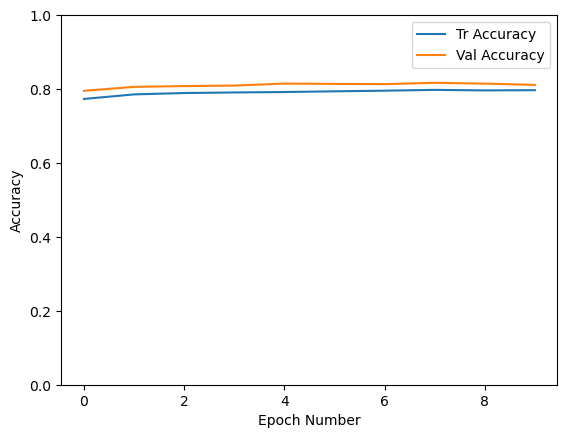

Getting predictions from test set…


In [23]:
FOLDER_PATH = "Results/Final/"

# Display Loss over training
history = torch.load(FOLDER_PATH+"history.pt")
print(history)
history = np.array(history)

plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig(dataset+'_loss_curve.png')
plt.show()

# Display accuracy over training
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

trained_model = pretrained_model
checkpoint = torch.load(FOLDER_PATH+"model_9.pt")
trained_model.load_state_dict(checkpoint['model'])
truelabels = []
predictions = []
trained_model.eval()
classes = [0,1]
print("Getting predictions from test set…")
# for data, target in test_dl:
#     for label in target.data.numpy():
#         truelabels.append(label)

def serialise_values( output_file = None, values = None, probabilities = False) :
	f = open(output_file, "w")
	if probabilities:
		for label, prob in values:
			f.write(str(label)+" "+str(prob)+"\n")
	else:
		for label in values:
			f.write(str(label)+"\n")
	f.close()

# serialise_values(FOLDER_PATH+"true_labels.txt", truelabels)

def get_true_labels(input_file = None, probabilities = False, uncropped = False):
	with open(input_file, 'r') as f:
		reader = f.readlines()
		label_list = []
		if probabilities:
			for line in reader:
				label = int(line[0])
				prob = float(line[2:-2])
				label_list.append([label, prob])
		elif uncropped:
			for line in reader:
				new_line = line[1:-2]
				split = new_line.split(", ")
				split[0] = split[0][1:-1]
				split[1] = float(split[1])
				label_list.append(split)
		else:			
			for line in reader:
				label_list.append(int(line[0]))
	return label_list

truelabels = get_true_labels(FOLDER_PATH+"true_labels.txt")

In [11]:
predictions_with_prob = []
predictions = []
def predict_test_set():
    for data, target in test_dl:
        for input_batch in data:
            input_batch = input_batch.unsqueeze(0)
            input_batch = input_batch.to(device)
            # Make prediction
            with torch.no_grad():
                output = trained_model(input_batch)

            # Get predicted class
            _, indices = torch.sort(output, descending=True)
            _, predicted_class = torch.max(output, 1)
            percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
            top_percent = percentage[predicted_class.item()].item()
            predictions_with_prob.append([predicted_class.item(),top_percent])
    return predictions_with_prob

# predicto = []
# for data, target in test_dl:
#     data = data.to(device)
#     # for label in target.data.numpy():
#     #     truelabels.append(label)
#     for prediction in trained_model(data):
#         predicto.append(torch.argmax(prediction).item())

# predictions_with_prob = predict_test_set()
# serialise_values(FOLDER_PATH+"predictions_with_prob.txt",values=predictions_with_prob,probabilities=True)

predictions_with_prob = get_true_labels(FOLDER_PATH+"predictions_with_prob.txt", probabilities=True)


In [12]:
precision_scores = []
recall_scores = []
print(len(predictions_with_prob))
print(len(truelabels))
predictions = []
for pred in predictions_with_prob:
    predictions.append(pred[0])

for p in range(1,100):
    test_preds = []

    for (pred, prob) in predictions_with_prob:
        # print(prob)
        if pred == 1:
            prob = 100 - prob
        if prob > p:
            test_preds.append(0)
        else:
            test_preds.append(1)

    recall = metrics.recall_score(truelabels, test_preds, pos_label=0, average='binary')
    precision = metrics.precision_score(truelabels, test_preds, pos_label=0, average='binary')
    precision_scores.append(precision)
    recall_scores.append(recall)

27100
27100


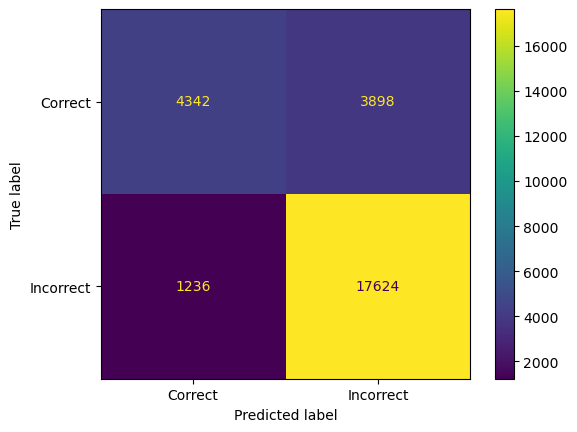

Recall Score: 0.5269417475728155
Precision Score: 0.7784152025815705
Fbeta Score: 0.7747544343155961
F1 Score:
0.6284556375741787


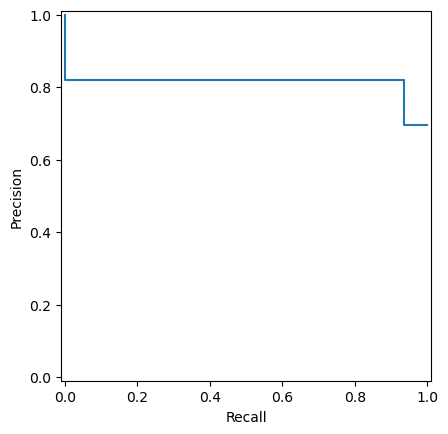

Final AUC: 0.72


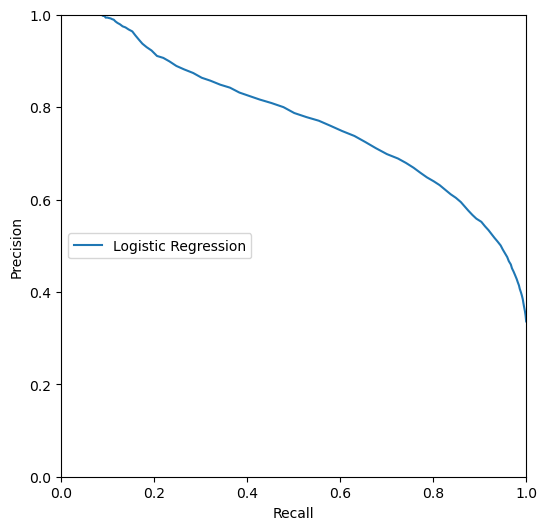

In [13]:
labels = ["Correct", "Incorrect"]
cm = metrics.confusion_matrix(truelabels, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
recall = metrics.recall_score(truelabels, predictions, pos_label=0, average='binary')
print("Recall Score:", recall)
precision = metrics.precision_score(truelabels, predictions, pos_label=0, average='binary')
print("Precision Score:", precision)
fbeta = metrics.fbeta_score(truelabels, predictions,beta=0.1, pos_label=0)
print("Fbeta Score:", fbeta)
print("F1 Score:")
f1 = metrics.f1_score(truelabels, predictions, pos_label=0,average='binary')
print(f1)
precision, recall, _ = metrics.precision_recall_curve(truelabels, predictions)
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores, precision_scores, label='Logistic Regression')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left')

print(f'Final AUC: {round(metrics.auc(recall_scores, precision_scores),2)}')

In [27]:
def predict(path):

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    zero_list = 0
    selected_images = []
    one_list = 0

    trained_model.eval()
    run = 0

    classes = [0,1]
    confidence_threshold = 54.1

    for i in range(0, 200):
        for j in range (0, 10):
            current_path = path + str(i)+"_"+str(j)+".jpg"
            image = Image.open(current_path)
            input_tensor = transform(image)
            input_batch = input_tensor.unsqueeze(0)
            input_batch = input_batch.to(device)

            # Make prediction
            with torch.no_grad():
                output = trained_model(input_batch)

            # Get predicted class
            _, indices = torch.sort(output, descending=True)
            _, predicted_class = torch.max(output, 1)
            percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
            # print([(classes[idx], percentage[idx].item()) for idx in indices[0][:2]])
            # print(f"Predicted class index: {predicted_class.item()}, Threshold:")
            # print(predicted_class.item())
            top_percent = percentage[predicted_class.item()].item()
            if (predicted_class.item()) == 0 and top_percent > confidence_threshold:
                zero_list += 1
                selected_images.append(current_path)
            else:
                one_list += 1
            run += 1
    
    print("Zeroes : ",zero_list)
    print("Ones : ",one_list)
    print("Run",run)

    return selected_images



TEST_PATH = "PetImages/TestCropped/Cat/"
cropped_predictions = predict(TEST_PATH)

Zeroes :  185
Ones :  1815
Run 2000


In [24]:
# Using ResNet to classify the original image vs the cropped versions
def guess_image(img):
    # Step 1: Initialize model with the best available weights
    weights = models.ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)
    model.eval()

    # Step 2: Initialize the inference transforms
    preprocess = weights.transforms()

    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(img).unsqueeze(0)

    # Step 4: Use the model and print the predicted category
    prediction = model(batch).squeeze(0).softmax(0)
    # print(prediction)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]

    # print(f"{category_name}: {100 * score:.1f}%")
    return category_name, 100 * score

with open('cat_labels.txt') as f:
    classes = [line.strip() for line in f.readlines()]


uncropped_results = []

UNCROPPED_PATH = "PetImages/TestCat/"
directory = os.fsencode(UNCROPPED_PATH)
# for file in os.listdir(directory):
#     filename = "PetImages/TestCat/Cat/" +os.fsdecode(file)
#     # print(filename)
#     img = Image.open(filename)
#     uncropped_results.append(guess_image(img))

uncropped_images = ImageFolder(UNCROPPED_PATH, transform=transforms.Compose([
                transforms.Resize((256,256)),
                # transforms.ToTensor(),
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))

def guess_images(image_folder):
    results = []
    for img, lab in image_folder:
        results.append(guess_image(img))
    return results

# uncropped_results = guess_images(uncropped_images)
# serialise_values("uncropped_results.txt", uncropped_results)

uncropped_results = get_true_labels("uncropped_results.txt", uncropped=True)
print(uncropped_results)

[['Egyptian cat', 29.681572318077087], ['Egyptian cat', 20.99125385284424], ['Egyptian cat', 24.101291596889496], ['tabby', 37.819769978523254], ['Egyptian cat', 15.664179623126984], ['lynx', 17.746250331401825], ['tabby', 9.405311942100525], ['Siberian husky', 6.870143115520477], ['Egyptian cat', 23.66534322500229], ['tabby', 18.615078926086426], ['tabby', 11.132965236902237], ['tabby', 42.817363142967224], ['Persian cat', 16.646620631217957], ['tabby', 26.370778679847717], ['lynx', 12.343490868806839], ['Siamese cat', 38.08482885360718], ['Egyptian cat', 29.95001971721649], ['Siamese cat', 20.030778646469116], ['Persian cat', 5.134019255638123], ['Egyptian cat', 17.524895071983337], ['Egyptian cat', 21.828003227710724], ['tabby', 23.146042227745056], ['carton', 23.321345448493958], ['Egyptian cat', 16.525638103485107], ['tabby', 9.706106036901474], ['Egyptian cat', 8.162693679332733], ['Cardigan', 4.714875295758247], ['tabby', 12.87703812122345], ['Egyptian cat', 29.509007930755615],

In [28]:
cropped_results = []
for path in predictions:
    img = Image.open(path)
    cropped_results.append(guess_image(img))


In [32]:
print(cropped_results)
serialise_values(FOLDER_PATH+"cropped_results.txt", cropped_results)
cropped_results = get_true_labels(FOLDER_PATH+"cropped_results.txt",uncropped=True)
print(cropped_results)

[('Egyptian cat', 18.151327967643738), ('Persian cat', 61.32726073265076), ('Persian cat', 42.12925136089325), ('Egyptian cat', 26.648157835006714), ('tabby', 21.255172789096832), ('tabby', 33.62935185432434), ('tabby', 46.164679527282715), ('tabby', 30.23233711719513), ('tabby', 27.31771171092987), ('Egyptian cat', 9.573355317115784), ('Egyptian cat', 10.394084453582764), ('Siberian husky', 2.8318868950009346), ('Egyptian cat', 14.21811431646347), ('Egyptian cat', 16.565071046352386), ('tabby', 12.632305920124054), ('tabby', 12.403444200754166), ('lion', 14.895933866500854), ('Egyptian cat', 21.10997885465622), ('Egyptian cat', 25.250080227851868), ('indri', 11.162961274385452), ('Pekinese', 36.289963126182556), ('tabby', 54.06837463378906), ('Persian cat', 20.847629010677338), ('tabby', 25.6909042596817), ('tiger cat', 10.866892337799072), ('Egyptian cat', 16.892848908901215), ('Egyptian cat', 41.99558198451996), ('tiger cat', 20.292291045188904), ('tiger cat', 29.16763126850128), ('

IndexError: list index out of range

In [29]:


def accuracy_of_cats(arr):
    total_correct = 0
    sum_loss = 0
    for prediction in arr:
        if prediction[0] in classes:
            total_correct += 1
            corrected_possibility = prediction[1] / 100 
        else:
            corrected_possibility = 1 - (prediction[1] / 100)
        log_corrected = math.log(corrected_possibility)
        sum_loss += log_corrected
    final_loss = -1/(len(arr))*sum_loss
    
    print("Total Correct:", str(total_correct), " Len arr", len(arr))
    accuracy = total_correct / len(arr) * 100
    return accuracy, final_loss

cropped_accuracy, crop_loss = accuracy_of_cats(cropped_results)
print("Cropped accuracy: "+str(cropped_accuracy)+"%")
print("Cropped loss: "+str(crop_loss))
uncropped_accuracy, uncropped_loss = accuracy_of_cats(uncropped_results)
print("Uncropped accuracy: "+str(uncropped_accuracy)+"%")
print("Uncropped loss: "+str(uncropped_loss))

Total Correct: 157  Len arr 185
Cropped accuracy: 84.86486486486487%
Cropped loss: 1.2907258781351023
Total Correct: 166  Len arr 200
Uncropped accuracy: 83.0%
Uncropped loss: 1.4274771042314545
